In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
  pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.3 MB/s eta 0:00:00


In [3]:
 import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm  # Timm provides pretrained models, including Vision Transformers
import matplotlib.pyplot as plt

In [4]:
 # Data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from torch.utils.data import random_split

# Load the full dataset
full_dataset = ImageFolder(root="/content/drive/MyDrive/Corn", transform=transform)

# Define the dataset lengths based on 65%, 25%, and 10% splits
train_size = int(0.65 * len(full_dataset))
val_size = int(0.25 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Remaining for test set

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [6]:
 # Create DataLoaders for each split
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=5)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, num_workers=5)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=5 )

# Print dataset sizes to confirm the split
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2503
Validation dataset size: 963
Test dataset size: 386


In [7]:
        # Load pretrained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [8]:
 # Freeze all layers except the last few for fine-tuning
for param in model.parameters():
    param.requires_grad = False
for param in model.blocks[-1].parameters():  # Fine-tuning only the last transformer block
    param.requires_grad = True
for param in model.head.parameters():  # Fine-tuning the classifier head
    param.requires_grad = True

In [9]:
  # Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [10]:
  # Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [11]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
  # Early stopping mechanism
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

In [13]:
 # Training loop
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(50):  # Increase the number of epochs if necessary
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= total
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Adjust the learning rate based on validation loss
    scheduler.step(val_loss)

Epoch [1/50], Train Loss: 2.2438, Train Acc: 0.2225, Val Loss: 1.5627, Val Acc: 0.4330
Epoch [2/50], Train Loss: 1.2656, Train Acc: 0.5725, Val Loss: 1.0355, Val Acc: 0.6698
Epoch [3/50], Train Loss: 0.9245, Train Acc: 0.6860, Val Loss: 0.7916, Val Acc: 0.7373
Epoch [4/50], Train Loss: 0.7209, Train Acc: 0.7515, Val Loss: 0.6203, Val Acc: 0.7871
Epoch [5/50], Train Loss: 0.5819, Train Acc: 0.7982, Val Loss: 0.5483, Val Acc: 0.8027
Epoch [6/50], Train Loss: 0.4920, Train Acc: 0.8254, Val Loss: 0.4526, Val Acc: 0.8349
Epoch [7/50], Train Loss: 0.4107, Train Acc: 0.8546, Val Loss: 0.4017, Val Acc: 0.8422
Epoch [8/50], Train Loss: 0.3677, Train Acc: 0.8722, Val Loss: 0.3611, Val Acc: 0.8702
Epoch [9/50], Train Loss: 0.3320, Train Acc: 0.8821, Val Loss: 0.3163, Val Acc: 0.8827
Epoch [10/50], Train Loss: 0.2963, Train Acc: 0.8933, Val Loss: 0.2901, Val Acc: 0.9055
Epoch [11/50], Train Loss: 0.2625, Train Acc: 0.9065, Val Loss: 0.3039, Val Acc: 0.8837
Epoch [12/50], Train Loss: 0.2590, Train 

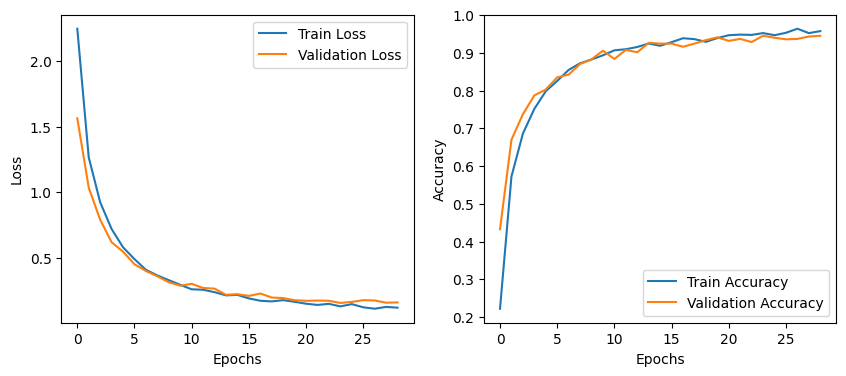

<ipython-input-14-ecde8106547c>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [14]:
 # Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

In [15]:
 # Define a path to save the model
model_save_path = '/content/drive/MyDrive/corn_vit_model.pth'  # Adjust the path as needed

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/corn_vit_model.pth


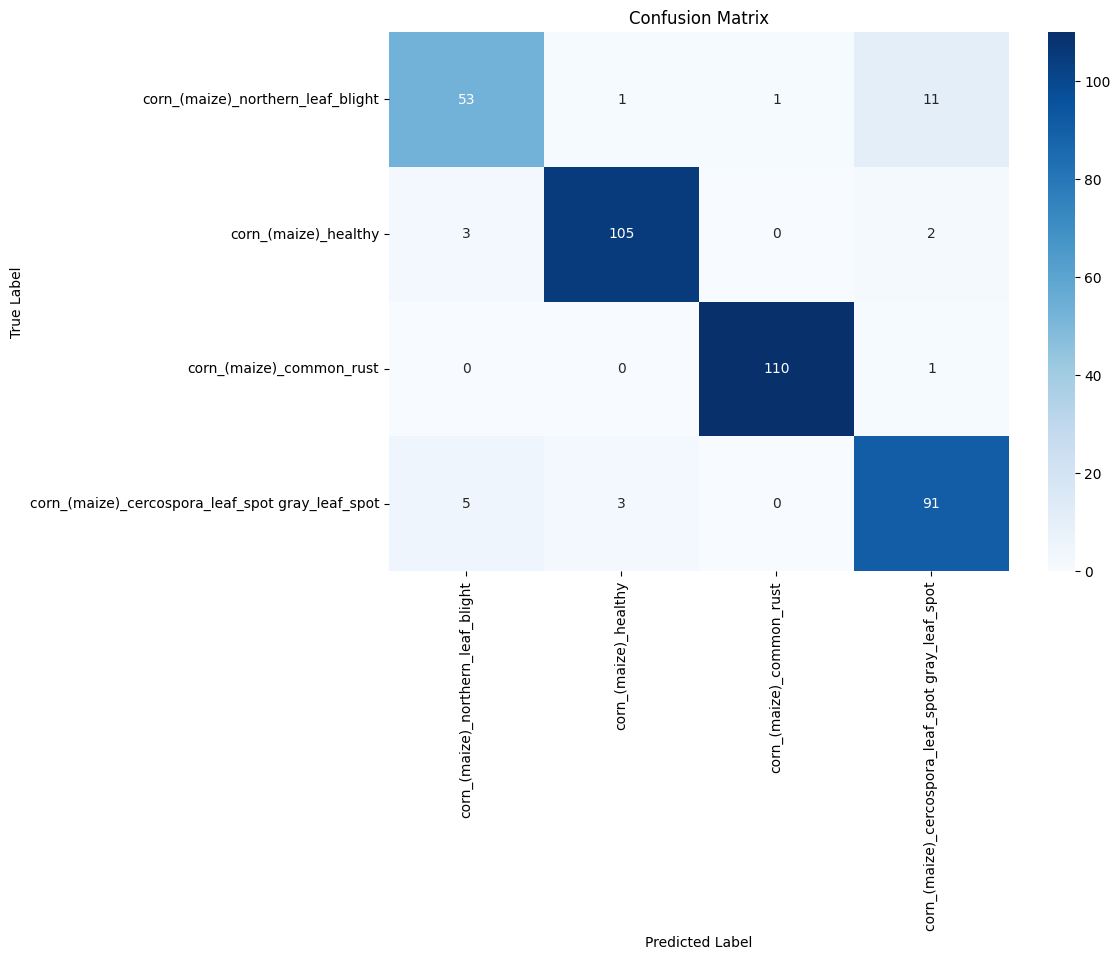

In [16]:
  import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have a list or dictionary of class names
class_names = ['corn_(maize)_northern_leaf_blight','corn_(maize)_healthy','corn_(maize)_common_rust','corn_(maize)_cercospora_leaf_spot gray_leaf_spot']  # Adjust based on your actual class labels

# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store the true and predicted labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Total Accuracy on test data: 96.09%


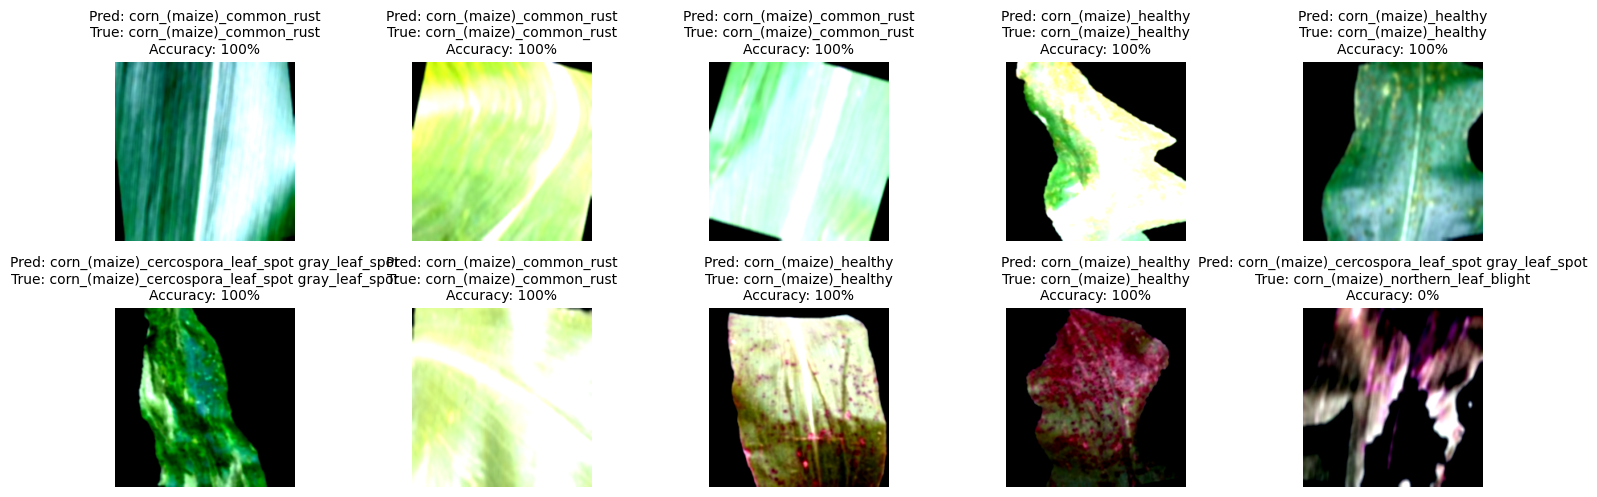

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list or dictionary of class names
class_names = ['corn_(maize)_northern_leaf_blight','corn_(maize)_healthy','corn_(maize)_common_rust','corn_(maize)_cercospora_leaf_spot gray_leaf_spot'] # Adjust based on your actual class labels

# Function to display an image in grid
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title, fontsize=10)
    plt.axis('off')

# Set model to evaluation mode
model.eval()

# Take a small batch of images from the test dataset
num_images = 10  # You can adjust this to 10-20
images_so_far = 0
fig = plt.figure(figsize=(15, 10))  # Adjust figure size to avoid text overlap

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Predict the output
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Display only the first num_images in grid
        for i in range(inputs.size()[0]):
            if images_so_far == num_images:
                break

            images_so_far += 1
            ax = plt.subplot(4, 5, images_so_far)  # Adjust grid size accordingly
            ax.axis('off')

            # Check if the prediction is correct
            is_correct = predicted[i] == labels[i]

            # Calculate prediction accuracy for this image (0 or 1)
            image_accuracy = 1 if is_correct else 0

            # Image title with prediction, true label, and accuracy for each image
            img_title = (f'Pred: {class_names[predicted[i]]}\n'
                         f'True: {class_names[labels[i]]}\n'
                         f'Accuracy: {image_accuracy * 100}%')

            imshow(inputs.cpu().data[i], title=img_title)

        if images_so_far == num_images:
            break

# Calculate total accuracy for the test batch
accuracy = 100 * correct / total
print(f'Total Accuracy on test data: {accuracy:.2f}%')

plt.tight_layout()
plt.show()


Saving a523ac3f-ae53-4da7-a3e1-7cce38714f75___RS_NLB 3812_final_masked.jpg to a523ac3f-ae53-4da7-a3e1-7cce38714f75___RS_NLB 3812_final_masked.jpg
Uploaded file: a523ac3f-ae53-4da7-a3e1-7cce38714f75___RS_NLB 3812_final_masked.jpg
File a523ac3f-ae53-4da7-a3e1-7cce38714f75___RS_NLB 3812_final_masked.jpg found.


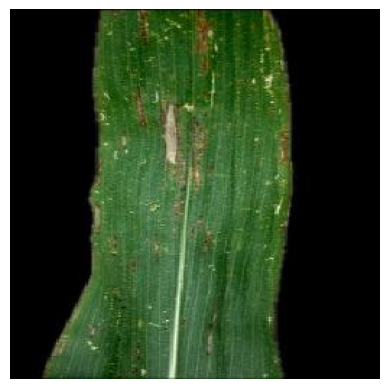

Description: Northern leaf blight is caused by the fungus Exserohilum turcicum. It causes gray-green lesions on leaves which can later turn tan as the disease progresses.
Cures: Plant resistant hybrids to reduce susceptibility to the disease., Rotate crops to reduce the amount of fungal spores in the soil., Apply fungicides, such as azoxystrobin or propiconazole, at early disease onset.
Predicted class: corn_(maize)_northern_leaf_blight 
confidence: 98.05


Description:
Northern leaf blight is caused by the fungus Exserohilum turcicum. It causes gray-green lesions on leaves which can later turn tan as the disease progresses.

Cures:
- Plant resistant hybrids to reduce susceptibility to the disease.
- Rotate crops to reduce the amount of fungal spores in the soil.
- Apply fungicides, such as azoxystrobin or propiconazole, at early disease onset.


In [39]:
 # Import necessary libraries
import torch
import torchvision.transforms as transforms
from google.colab import files
from PIL import Image
import os
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt  # Importing matplotlib for image display

# Function to display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()  # Show the image

# Function to make predictions on images and plot them with prediction confidence
def pred_and_plot_image(model, image_path, class_names, device):
    # Load image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # Assuming your model uses 224x224 image size

    # Preprocess image (adjust based on your model's preprocessing)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img)  # Get raw model outputs (logits)
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Get the class with highest probability

    # Get class name and confidence
    predicted_class_name = class_names[predicted_class.item()]
    predicted_confidence = confidence.item()

    # Return result
    return predicted_class_name, predicted_confidence

# Assuming you used ImageFolder to load your dataset for training
# This will extract the class names automatically from your dataset folder structure
dataset = ImageFolder(root="/content/drive/MyDrive/Corn", transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))
class_names = dataset.classes  # Extract class names from the dataset

# Upload the image from local machine
uploaded = files.upload()

# Get the uploaded file name
image_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {image_filename}")

# Ensure the uploaded image file exists
if os.path.isfile(image_filename):
    print(f"File {image_filename} found.")
else:
    raise FileNotFoundError(f"{image_filename} not found. Please upload the file.")

# Display the uploaded image
display_image(image_filename)  # Call the display function to show the image

# Assuming 'vit' is your model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Move model to GPU if available

# Call the prediction function
predicted_class_name, predicted_confidence = pred_and_plot_image(model, image_path=image_filename, class_names=class_names, device=device)

# Define your corn disease cure database
disease_cure_database = {
    "corn_(maize)_northern_leaf_blight": {
        "description": "Northern leaf blight is caused by the fungus Exserohilum turcicum. It causes gray-green lesions on leaves which can later turn tan as the disease progresses.",
        "cures": [
            "Plant resistant hybrids to reduce susceptibility to the disease.",
            "Rotate crops to reduce the amount of fungal spores in the soil.",
            "Apply fungicides, such as azoxystrobin or propiconazole, at early disease onset."
        ]
    },
    "corn_(maize)_healthy": {
        "description": "No disease present; ensure ongoing healthy practices to maintain crop health.",
        "cures": [
            "Ensure good crop rotation to reduce disease pressure.",
            "Maintain proper spacing between plants to promote airflow and reduce moisture accumulation.",
            "Apply balanced fertilizers to ensure optimal growth and inspect regularly for pests."
        ]
    },
    "corn_(maize)_common_rust": {
        "description": "Common rust in corn is caused by the fungus Puccinia sorghi. It results in the formation of reddish-brown pustules on leaves and stems.",
        "cures": [
            "Plant rust-resistant hybrids to reduce disease incidence.",
            "Use fungicides like azoxystrobin or pyraclostrobin when rust levels are high.",
            "Avoid overhead irrigation to reduce moisture on the leaves, which promotes rust growth."
        ]
    },
    "corn_(maize)_cercospora_leaf_spot_gray_leaf_spot": {
        "description": "Gray leaf spot is caused by the fungus Cercospora zeae-maydis. It forms gray, rectangular lesions on the leaves and can reduce photosynthesis.",
        "cures": [
            "Plant resistant hybrids or use high-quality seeds treated with fungicides.",
            "Rotate crops to reduce pathogen buildup in the soil.",
            "Apply foliar fungicides like strobilurins (e.g., azoxystrobin) or triazoles (e.g., propiconazole) when disease pressure is high."
        ]
    }
}

# Example of how you can access data for Northern Leaf Blight:
print(f"Description: {disease_cure_database['corn_(maize)_northern_leaf_blight']['description']}")
print(f"Cures: {', '.join(disease_cure_database['corn_(maize)_northern_leaf_blight']['cures'])}")


# Display the predicted class and confidence
print(f"Predicted class: {predicted_class_name} \nconfidence: {predicted_confidence * 100:.2f}\n\n")

# Display the disease description and cure if found in the database
if predicted_class_name in disease_cure_database:
    disease_info = disease_cure_database[predicted_class_name]

    print(f"Description:\n{disease_info['description']}\n")
    print("Cures:")
    for cure in disease_info['cures']:
        print(f"- {cure}")

else:
    print(f"No information available for the predicted class: {predicted_class_name}")
